In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid",
        rc={"figure.figsize":(12,8), 
            "axes.labelsize":14, 
            "xtick.labelsize":12, 
            "ytick.labelsize":12})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
tr = pd.read_csv("../data/train.csv")
te = pd.read_csv("../data/test.csv")
data = pd.concat([tr, te])

print tr.shape
print te.shape
print data.shape

(1460, 81)
(1459, 80)
(2919, 81)


# Explore variables one at a time

In [3]:
# drop ID
data.drop(["Id"], axis = 1, inplace=True)

In [4]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


## MSSubClass

In [5]:
data["MSSubClass"].isnull().sum()

0

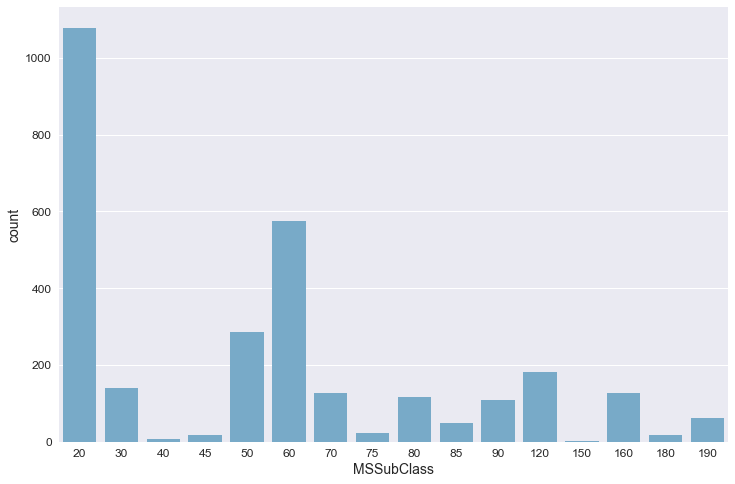

In [6]:
sns.countplot(x="MSSubClass", data=data, palette=sns.color_palette("Blues", 1));

MSSubClass is categorical, though it is coded as numeric. Combine all the 1 and 1.5 story dwelling types as 1, 2 and 2.5 story types as 2, and the rest as 0.

In [7]:
MSSubClass = data["MSSubClass"] \
            .replace([20, 30, 40, 45, 50, 120, 150], 1) \
            .replace([60, 70, 75, 160], 2) \
            .replace([80, 85, 90, 180, 190], 0)

In [8]:
new = pd.DataFrame({"MSSubClass": MSSubClass})  # create new dataframe
new["MSSubClass"].value_counts()

1    1712
2     854
0     353
Name: MSSubClass, dtype: int64

## MSZoning

In [9]:
data["MSZoning"].isnull().sum()

4

In [10]:
data["MSZoning"].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [11]:
# Residential zone?: Y (1) or N (0)
MSZoning = data["MSZoning"].fillna("RL").map(lambda x: 1 if (x == "RL") or (x == "RM") else 0)
pd.Series(MSZoning).value_counts()

1    2729
0     190
Name: MSZoning, dtype: int64

MSZoning has a severe lack of variability, providing little-to-no information in predicting SalePrice. Thus, this variable will not be used in the model. 

## LotFrontage

In [12]:
data["LotFrontage"].describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [13]:
new["LotFrontage"] = data["LotFrontage"].fillna(data["LotFrontage"].median())
new["LotFrontage"].describe()

count    2919.000000
mean       69.088386
std        21.317898
min        21.000000
25%        60.000000
50%        68.000000
75%        78.000000
max       313.000000
Name: LotFrontage, dtype: float64

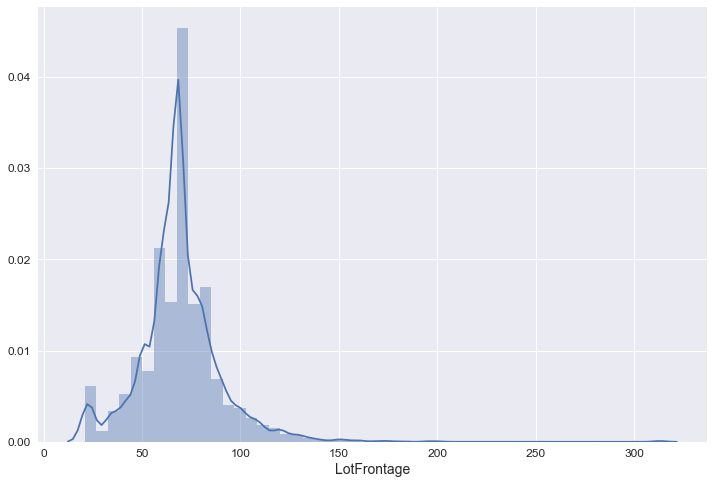

In [14]:
sns.distplot(new["LotFrontage"]);

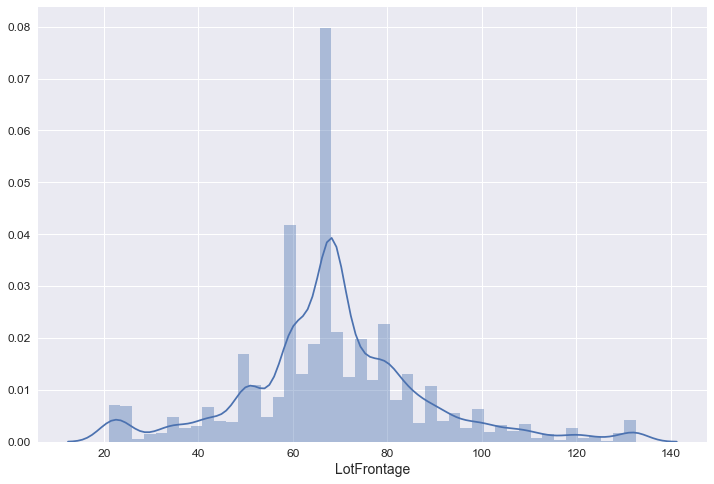

In [15]:
# Handle outliers
lowerbound, upperbound = np.percentile(new["LotFrontage"], [1, 99])  # calculate 1st and 99th percentile
new["LotFrontage"] = np.clip(new["LotFrontage"], upperbound, lowerbound)  # clip values outside these percentile range
sns.distplot(new["LotFrontage"]);

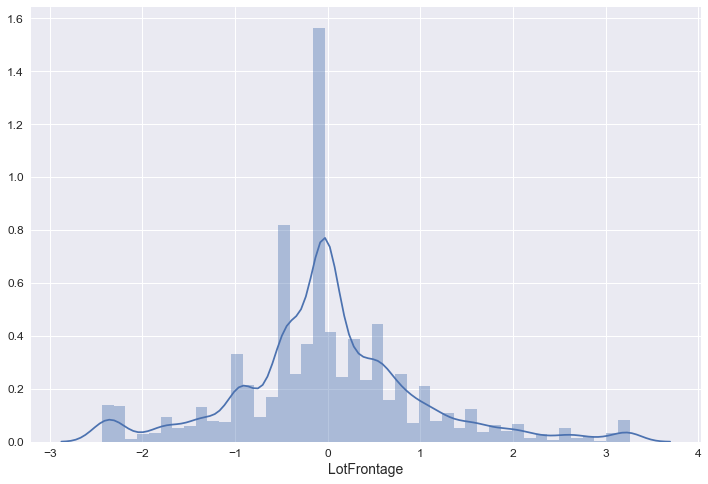

In [16]:
# Rescale numeric features to mean 0 and std dev 1
scaler = StandardScaler()
new["LotFrontage"] = scaler.fit_transform(new[["LotFrontage"]]) 
sns.distplot(new["LotFrontage"]);

## LotArea

In [17]:
data["LotArea"].describe()

count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
25%        7478.000000
50%        9453.000000
75%       11570.000000
max      215245.000000
Name: LotArea, dtype: float64

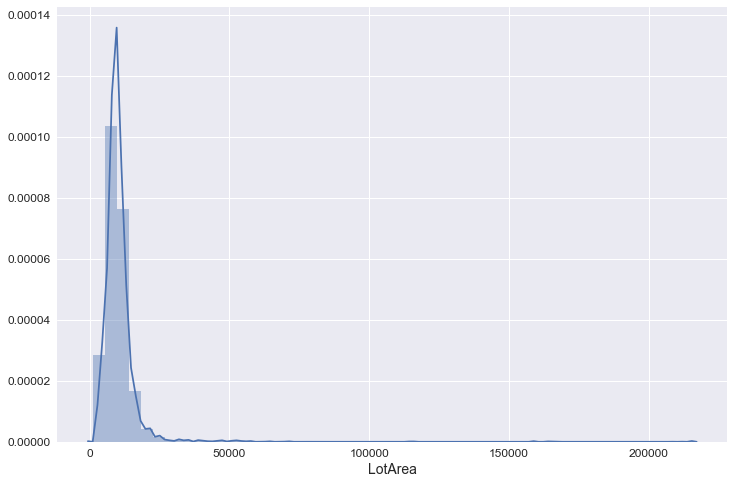

In [18]:
sns.distplot(data["LotArea"]);

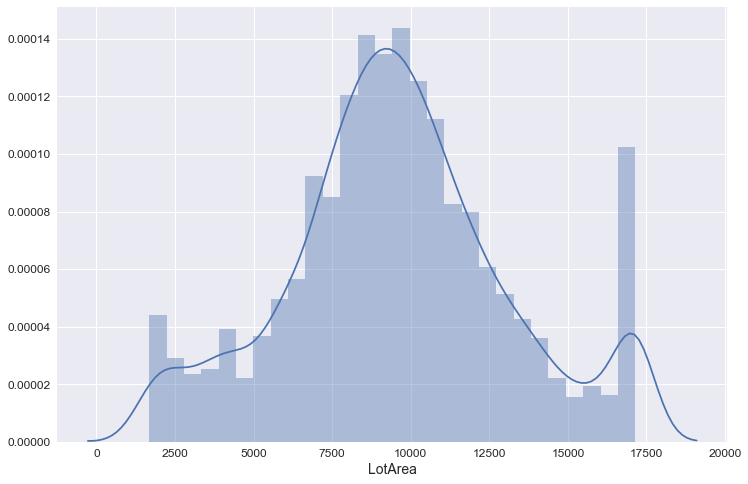

In [19]:
lowerbound, upperbound = np.percentile(data["LotArea"], [1, 95])
new["LotArea"] = np.clip(data["LotArea"], lowerbound, upperbound)
sns.distplot(new["LotArea"]);

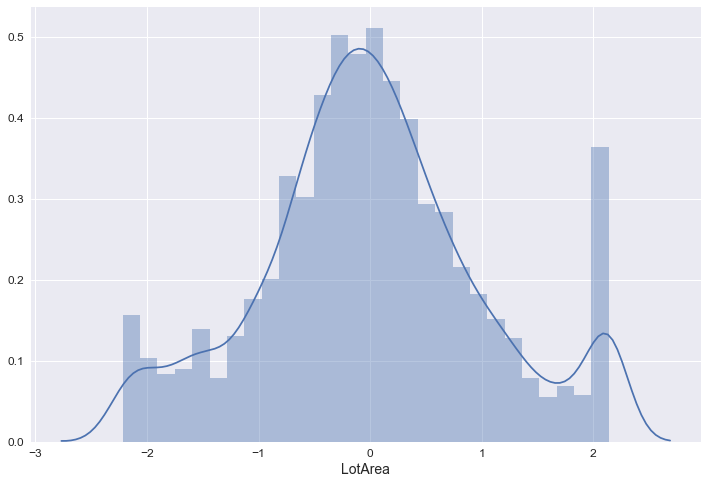

In [20]:
new["LotArea"] = scaler.fit_transform(new[["LotArea"]]) 
sns.distplot(new["LotArea"]);

## Street and PavedDrive

In [21]:
data["Street"].isnull().sum()

0

In [22]:
data["Street"].value_counts()

Pave    2907
Grvl      12
Name: Street, dtype: int64

In [23]:
data["PavedDrive"].isnull().sum()

0

In [24]:
data["PavedDrive"].value_counts()

Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64

In [25]:
# Paved driveway?: Y (1) or No (0)
PavedDrive = np.where(data["PavedDrive"] == "Y", 1, 0)
pd.Series(PavedDrive).value_counts()

1    2641
0     278
dtype: int64

Street and PavedDrive have severe lack of variability, providing little-to-no information in predicting SalePrice. Thus, these variables will not be used in the model.

## Alley

In [26]:
data["Alley"].isnull().sum()

2721

NA means that houses have no alley, which is not the same as a missing value. Drop this variable since it lacks variability and provides limited information towards the prediction.

## LotShape

In [27]:
data["LotShape"].isnull().sum()

0

In [28]:
data["LotShape"].value_counts()

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

In [29]:
# Regular lot shape?: Y (1) or No (0)
new["LotShape"] = np.where(data["LotShape"] == "Reg", 1, 0)
new["LotShape"].value_counts()

1    1859
0    1060
Name: LotShape, dtype: int64

## LandContour

In [30]:
data["LandContour"].isnull().sum()

0

In [31]:
data["LandContour"].value_counts()

Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64

In [32]:
# Flat land?: Y (1) or No (0)
LandContour = np.where(data["LandContour"] == "Lvl", 1, 0)
pd.Series(LandContour).value_counts()

1    2622
0     297
dtype: int64

Drop LandContour due to lack of variability in its values. 

## Utilities

Drop Utilities due to severe lack of variability!

In [33]:
data["Utilities"].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

## LotConfig

In [34]:
data["LotConfig"].isnull().sum()

0

In [35]:
data["LotConfig"].value_counts()

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

In [36]:
# Inside lot?: Y (1) or No (0)
new["LotConfig"] = np.where(data["LotConfig"] == "Inside", 1, 0)
new["LotConfig"].value_counts()

1    2133
0     786
Name: LotConfig, dtype: int64

## LandSlope

Drop LandSlope due to lack of variability

In [37]:
data["LandSlope"].isnull().sum()

0

In [38]:
data["LandSlope"].value_counts()

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

In [39]:
# Gentle slope?: Y (1) or No (0)
LandSlope = np.where(data["LandSlope"] == "Gtl", 1, 0)
pd.Series(LandSlope).value_counts()

1    2778
0     141
dtype: int64

## Neighborhood

In [40]:
data["Neighborhood"].isnull().sum()

0

In [41]:
data["Neighborhood"].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

In [42]:
# Frequency Encoding
freqNghd = data.groupby("Neighborhood").size() / len(data)
new["Neighborhood"] = data["Neighborhood"].map(freqNghd)
new["Neighborhood"].value_counts()

0.151764    443
0.091470    267
0.081877    239
0.066461    194
0.062350    182
0.056869    166
0.056526    165
0.051730    151
0.044878    131
0.042823    125
0.039054    114
0.036999    108
0.035286    103
0.031860     93
0.024666     72
0.024323     71
0.017472     51
0.016444     48
0.015074     44
0.012676     37
0.010277     30
0.009592     28
0.008222     24
0.007879     23
0.003426     10
Name: Neighborhood, dtype: int64

## Condition1 and Condition2

In [43]:
data["Condition1"].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [44]:
data["Condition2"].value_counts()

Norm      2889
Feedr       13
Artery       5
PosA         4
PosN         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

Most houses have normal condition. If either conditions are normal, record the overall condition as normal. 

In [45]:
Condition = np.logical_or(data["Condition1"] == "Norm", data["Condition2"] == "Norm")
Condition.value_counts()

True     2889
False      30
Name: Condition1, dtype: int64

Drop this variable since it lacks variability.

## BldgType

In [46]:
data["BldgType"].isnull().sum()

0

In [47]:
data["BldgType"].value_counts()

1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

In [48]:
# Single-family detached?: Y (1) or N (0)
BldgType = np.where(data["BldgType"] == "1Fam", 1, 0)
pd.Series(BldgType).value_counts()

1    2425
0     494
dtype: int64

Drop BldgType due to lack of variability

## HouseStyle

In [49]:
data["HouseStyle"].isnull().sum()

0

In [50]:
data["HouseStyle"].value_counts()

1Story    1471
2Story     872
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64

Combine 1-1.5 story as 1, 2-2.5 story as 2, and the rest as 0.

In [51]:
new["HouseStyle"] = data["HouseStyle"].replace(["1Story", "1.5Fin", "1.5Unf"], 1) \
.replace(["2Story", "2.5Fin", "2.5Unf"], 2) \
.replace(["SFoyer", "SLvl"], 0)
new["HouseStyle"].value_counts()

1    1804
2     904
0     211
Name: HouseStyle, dtype: int64

## OverallQual

In [52]:
data["OverallQual"].isnull().sum()

0

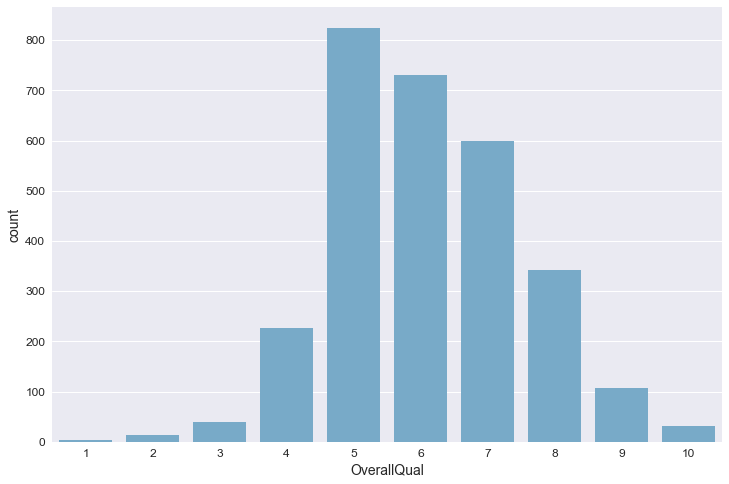

In [53]:
sns.countplot(x="OverallQual", data=data, palette=sns.color_palette("Blues", 1));

Combine very poor/poor/fair/less than average  as -1, average/above average/good as 0, very good/excellent/very excellent as 1.

In [54]:
OverallQual = data["OverallQual"].map(lambda x: -1 if x < 4 else 0 if x < 8 else 1)
pd.Series(OverallQual).value_counts()

 0    2382
 1     480
-1      57
Name: OverallQual, dtype: int64

Drop OverallQual due to lack of variability

## OverallCond

Drop OverallCond due to lack of variability

In [55]:
data["OverallCond"].isnull().sum()

0

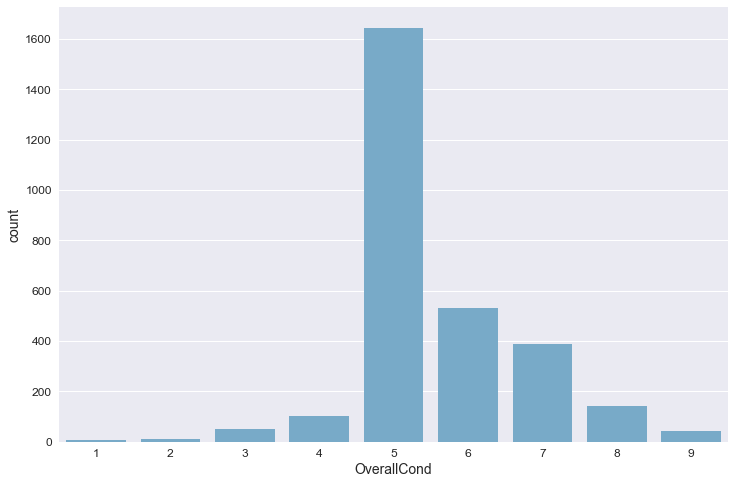

In [56]:
sns.countplot(x="OverallCond", data=data, palette=sns.color_palette("Blues", 1));

In [57]:
# Above average condition?: Y (1) or No (0)
OverallCond = np.where(data["OverallCond"] > 4, 1, 0)
pd.Series(OverallCond).value_counts()

1    2751
0     168
dtype: int64

## YearBuilt 

In [58]:
data["YearBuilt"].describe()

count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
25%      1953.500000
50%      1973.000000
75%      2001.000000
max      2010.000000
Name: YearBuilt, dtype: float64

Years usually needs to be binned. Let 0 = ancient, 1 = older, 2 = newer, 3 = modern indicate the age of the house.

In [59]:
new["YearBuilt"] = pd.qcut(data["YearBuilt"], q = 4, labels = [0, 1, 2, 3])
pd.concat((new["YearBuilt"], data["YearBuilt"]), axis = 1).head()

,YearBuilt,YearBuilt
0,3,2003
1,2,1976
2,2,2001
3,0,1915
4,2,2000


In [60]:
new["YearBuilt"].value_counts()

2    748
1    741
0    730
3    700
Name: YearBuilt, dtype: int64

## YearRemodAdd

In [61]:
data["YearRemodAdd"].describe()

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

In [62]:
remodel = np.subtract(data["YearRemodAdd"], data["YearBuilt"])
remodel.describe()

count    2919.000000
mean       12.951696
std        24.065624
min        -1.000000
25%         0.000000
50%         0.000000
75%        18.000000
max       127.000000
Name: YearRemodAdd, dtype: float64

In [63]:
# House remodeled? Y (1) or No (0)
new["RemodAdd"] = pd.Series(remodel.map(lambda x: 0 if x <= 0 else 1))
new["RemodAdd"].value_counts()

0    1561
1    1358
Name: RemodAdd, dtype: int64

## RoofStyle

Drop RoofStyle due to lack of variability

In [64]:
data["RoofStyle"].isnull().sum()

0

In [65]:
data["RoofStyle"].value_counts()

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

In [66]:
# Gable roof?: Y (1) or No (0)
RoofStyle = np.where(data["RoofStyle"] == "Gable", 1, 0)
pd.Series(RoofStyle).value_counts()

1    2310
0     609
dtype: int64

## RoofMatl

Drop this variable since it heavily lacks variability.

In [67]:
data["RoofMatl"].isnull().sum()

0

In [68]:
data["RoofMatl"].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
ClyTile       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

In [69]:
# Standard shingle?: Y (1) or N (0)
RoofMatl = pd.Series(np.where(data["RoofMatl"] == "CompShg", 1, 0))
RoofMatl.value_counts()

1    2876
0      43
dtype: int64

## Exterior1st and Exterior2nd

In [70]:
print data["Exterior1st"].isnull().sum()
print data["Exterior2nd"].isnull().sum()

1
1


In [71]:
data["Exterior1st"].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

In [72]:
Exterior1st = data["Exterior1st"].fillna("Other") \
.replace(["BrkFace", "WdShing", "AsbShng", "Stucco", "BrkComm", "AsphShn", "Stone", "CBlock", "ImStucc", "Other"], "Other")
Exterior1st.value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Other       244
Plywood     221
CemntBd     126
Name: Exterior1st, dtype: int64

In [73]:
data["Exterior2nd"].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [74]:
Exterior2nd = data["Exterior2nd"].fillna("Other") \
.replace(["Wd Shng", "BrkFace", "Stucco", "AsbShng", "Brk Cmn", "ImStucc", "Stone", "AsphShn", "CBlock", "Other"], "Other")
Exterior2nd.value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
Other       265
CmentBd     126
Name: Exterior2nd, dtype: int64

In [75]:
np.equal(Exterior1st, Exterior2nd).value_counts()  # check if both columns are same

True     2544
False     375
Name: Exterior1st, dtype: int64

Since both variables roughly have the same distribution and most houses have only one exterior material, keep only one of them in the model.

In [76]:
new["Exterior"] = Exterior1st
new["Exterior"].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Other       244
Plywood     221
CemntBd     126
Name: Exterior, dtype: int64

In [77]:
# Frequency Encoding
freqExt = new.groupby("Exterior").size() / len(new)
new["Exterior"] = new["Exterior"].map(freqExt)
new["Exterior"].value_counts()

0.351148    1025
0.154162     450
0.151422     442
0.140802     411
0.083590     244
0.075711     221
0.043165     126
Name: Exterior, dtype: int64

## MasVnrType and MasVnrArea

In [78]:
data["MasVnrArea"].describe()

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [79]:
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
np.sum(data["MasVnrArea"] == 0)

1761

Since about half the houses don't have masonry veneer walls, the area is mostly 0.

In [80]:
data["MasVnrType"].isnull().sum()

24

In [81]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrType"].value_counts()

None       1766
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

It makes more sense to simply record if a house has masonry veneer rather than worrying about unnecessary details, such as its area and type.

In [82]:
new["MasVnr"] = np.where(data["MasVnrArea"] == 0, 0, 1)
new["MasVnr"].value_counts()

0    1761
1    1158
Name: MasVnr, dtype: int64

## ExterQual and ExterCond

In [83]:
print data["ExterQual"].isnull().sum()
print data["ExterCond"].isnull().sum()

0
0


Compare the original quality of the material to its current condition.

In [84]:
original = data["ExterQual"].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1})
current = data["ExterCond"].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1})
original.value_counts()

3    1798
4     979
5     107
2      35
Name: ExterQual, dtype: int64

In [85]:
current.value_counts()

3    2538
4     299
2      67
5      12
1       3
Name: ExterCond, dtype: int64

In [86]:
# Get the change in condition over time
cond = np.subtract(current, original)
cond.value_counts()

 0    1620
-1     951
 1     237
-2     104
 2       7
Name: ExterCond, dtype: int64

Let -1 = depreciated, 0 = no change, 1 = improved indicate the change in condition over time

In [87]:
new["ExterCond"] = pd.Series(cond.map(lambda x: -1 if x < 0 else 1 if x > 0 else 0))
new["ExterCond"].value_counts()

 0    1620
-1    1055
 1     244
Name: ExterCond, dtype: int64

## Foundation

In [88]:
data["Foundation"].isnull().sum()

0

In [89]:
data["Foundation"].value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64

In [90]:
new["Foundation"] = data["Foundation"].replace(["BrkTil", "Slab", "Stone", "Wood"], "Other")
new["Foundation"].value_counts()

PConc     1308
CBlock    1235
Other      376
Name: Foundation, dtype: int64

In [91]:
# Frequency Encoding
freqFd = new.groupby("Foundation").size() / len(new)
new["Foundation"] = new["Foundation"].map(freqFd)
new["Foundation"].value_counts()

0.448099    1308
0.423090    1235
0.128811     376
Name: Foundation, dtype: int64

## BsmtQual

This variable records the basement height.

In [92]:
data["BsmtQual"].isnull().sum()

81

In [93]:
data["BsmtQual"].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

NA means no basement, and not missing.

In [94]:
new["BsmtQual"] = data["BsmtQual"].fillna("None").map({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 1, "None": 0})
new["BsmtQual"].value_counts()

2    1283
3    1209
4     258
1      88
0      81
Name: BsmtQual, dtype: int64

## BsmtCond

In [95]:
data["BsmtCond"].isnull().sum()

82

In [96]:
data["BsmtCond"].value_counts()

TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

NA means no basement, and not missing.

In [97]:
BsmtCond = data["BsmtCond"].fillna("None")
BsmtCond.value_counts()

TA      2606
Gd       122
Fa       104
None      82
Po         5
Name: BsmtCond, dtype: int64

In [98]:
# Typical basement condition?: Y (1) or No (0)
BsmtCond = data["BsmtCond"].fillna("None")
BsmtCond = np.where(BsmtCond == "TA", 1, 0)
pd.Series(BsmtCond).value_counts()

1    2606
0     313
dtype: int64

Drop BsmtCond due to lack of variability

## BsmtExposure

In [99]:
data["BsmtExposure"].isnull().sum()

82

NA means no basement, and not missing.

In [100]:
data["BsmtExposure"].value_counts()

No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64

In [101]:
# Has a walkout or garden level walls?: Y (1) or No (0)
new["BsmtExposure"] = data["BsmtExposure"].fillna("None").map({"Gd": 1, "Av": 1, "Mn": 1, "No": 0, "None": 0})
new["BsmtExposure"].value_counts()

0    1986
1     933
Name: BsmtExposure, dtype: int64

## BsmtFinType1 and BsmtFinType2

In [102]:
print data["BsmtFinType1"].isnull().sum()
print data["BsmtFinType2"].isnull().sum()

79
80


NA means no basement, and not missing.

In [103]:
data["BsmtFinType1"].value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

In [104]:
data["BsmtFinType2"].value_counts()

Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [105]:
type1 = data["BsmtFinType1"].fillna("None").map({"GLQ": 3, "ALQ": 2, "Rec": 2, "BLQ": 1, "LwQ": 1, "Unf": 0, "None": 0})
type2 = data["BsmtFinType2"].fillna("None").map({"GLQ": 3, "ALQ": 2, "Rec": 2, "BLQ": 1, "LwQ": 1, "Unf": 0, "None": 0})
type1.value_counts()

0    930
3    849
2    717
1    423
Name: BsmtFinType1, dtype: int64

In [106]:
type2.value_counts()

0    2573
2     157
1     155
3      34
Name: BsmtFinType2, dtype: int64

In [107]:
np.equal(type1, type2).value_counts()  # most basements have a 2nd rating

False    1899
True     1020
Name: BsmtFinType1, dtype: int64

Most basements can be used as a living quarter, however that space is unfinished. Hence, it makes more sense here to record if the basement is unfinished and use TotalBsmtSF to provide the total basement area.

In [108]:
# Unfinished basement?
BsmtFinType = pd.Series(np.logical_or(type1 == 0.0, type2 == 0.0))
pd.Series(BsmtFinType).value_counts()

True     2573
False     346
Name: BsmtFinType1, dtype: int64

Drop BsmtFinType due to lack of variability

## BsmtFinSF1, BsmtFinSF2, BsmtUnfSF

In [109]:
data["BsmtFinSF1"].describe()

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

In [110]:
data["BsmtFinSF2"].describe()

count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64

In [111]:
print (data["BsmtFinSF1"] == 0).sum()
print (data["BsmtFinSF2"] == 0).sum()

929
2571


Since most basements are unfinished, there are just as many zeroes as in type1 and type2.

In [112]:
BsmtFinSF = np.logical_or(data["BsmtFinSF1"] == 0, data["BsmtFinSF2"] == 0)
(BsmtFinSF == True).sum()

2571

Drop this variable since it is redundant with BsmtFinType.

In [113]:
data["BsmtUnfSF"].describe()

count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
25%       220.000000
50%       467.000000
75%       805.500000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

In [114]:
(data["BsmtUnfSF"] != 0).sum()

2678

There are many nonzero values since most basements are unfinished. Drop this variable since it is redundant with BsmtFinType.

## TotalBsmtSF

In [115]:
data["TotalBsmtSF"].describe()

count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [116]:
new["TotalBsmtSF"] = data["TotalBsmtSF"].fillna(data["TotalBsmtSF"].median())

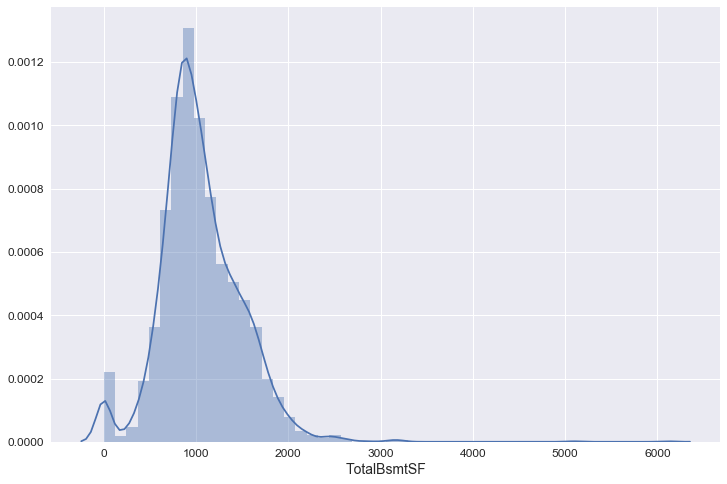

In [117]:
sns.distplot(new["TotalBsmtSF"]);

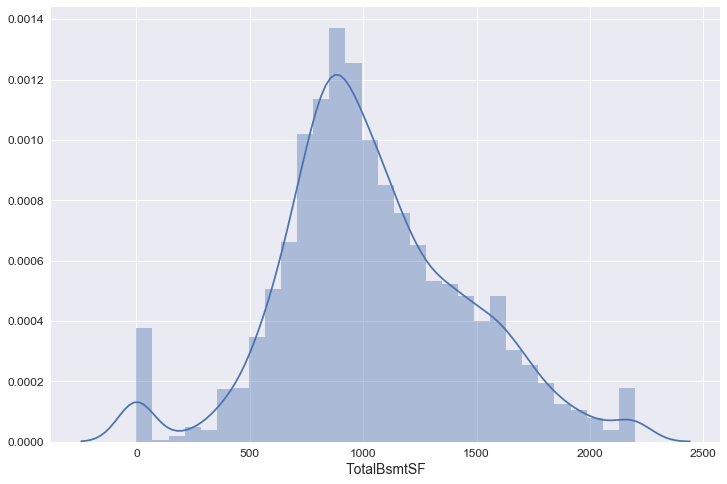

In [118]:
lowerbound, upperbound = np.percentile(new["TotalBsmtSF"], [1, 99])
new["TotalBsmtSF"] = np.clip(new["TotalBsmtSF"], lowerbound, upperbound)
sns.distplot(new["TotalBsmtSF"]);

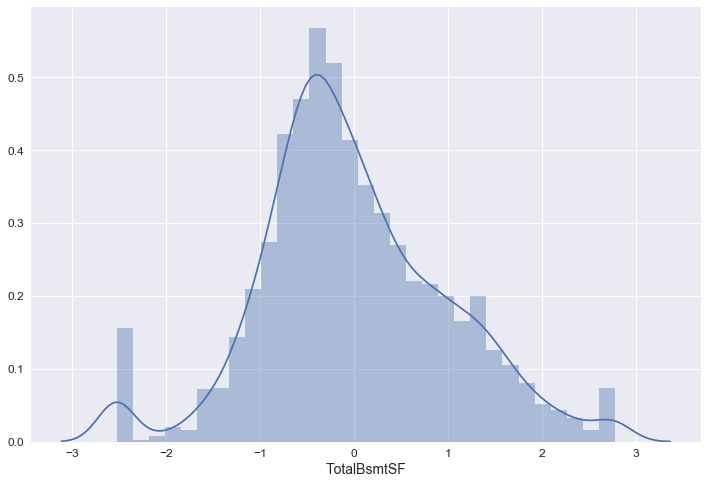

In [119]:
new["TotalBsmtSF"] = scaler.fit_transform(new[["TotalBsmtSF"]]) 
sns.distplot(new["TotalBsmtSF"]);

## Heating

In [120]:
data["Heating"].value_counts()

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

In [121]:
# Has gas air furnace?: Y (1) or No (0)
Heating = pd.Series(np.where(data["Heating"] == "GasA", 1, 0))
Heating.value_counts()

1    2874
0      45
dtype: int64

Drop Heating since it severely lacks variability

## HeatingQC

In [122]:
data["HeatingQC"].isnull().sum()

0

In [123]:
data["HeatingQC"].value_counts()

Ex    1493
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64

In [124]:
new["HeatingQC"] = data["HeatingQC"].map({"Ex": 3, "Gd": 2, "TA": 2, "Fa": 1, "Po": 1})
new["HeatingQC"].value_counts()

3    1493
2    1331
1      95
Name: HeatingQC, dtype: int64

## CentralAir

Drop CentralAir since it lacks variability

In [125]:
data["CentralAir"].isnull().sum()

0

In [126]:
data["CentralAir"].value_counts()

Y    2723
N     196
Name: CentralAir, dtype: int64

## Electrical

Drop Electrical since it lacks variability

In [127]:
data["Electrical"].isnull().sum()

1

In [128]:
data["Electrical"].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [129]:
# Standard breaker?: Y (1) or No (0)
Electrical = np.where(data["Electrical"] == "SBrkr", 1, 0)
pd.Series(Electrical).value_counts()

1    2671
0     248
dtype: int64

## 1stFlrSF

In [130]:
data["1stFlrSF"].describe()

count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
25%       876.000000
50%      1082.000000
75%      1387.500000
max      5095.000000
Name: 1stFlrSF, dtype: float64

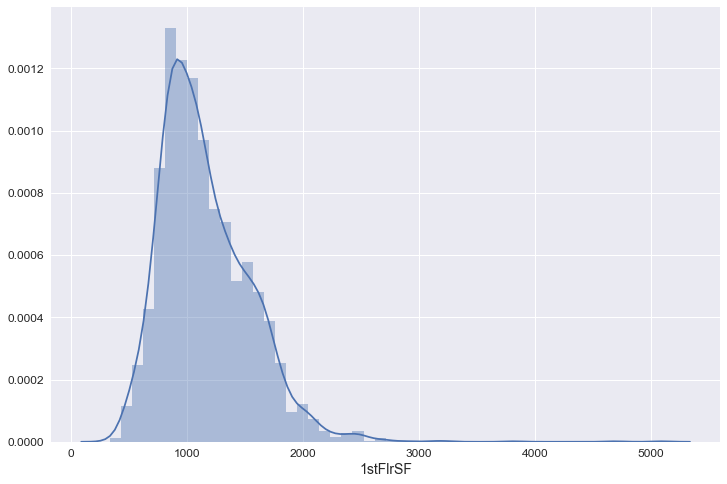

In [131]:
sns.distplot(data["1stFlrSF"]);

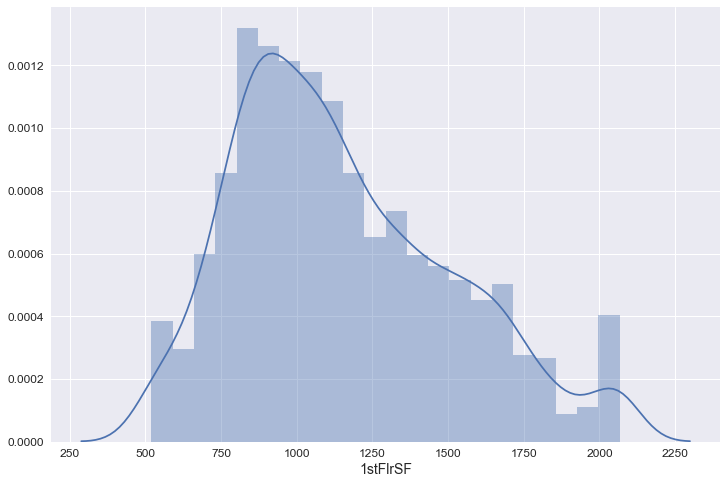

In [132]:
lowerbound, upperbound = np.percentile(data["1stFlrSF"], [1, 98])
new["1stFlrSF"] = np.clip(data["1stFlrSF"], lowerbound, upperbound)
sns.distplot(new["1stFlrSF"]);

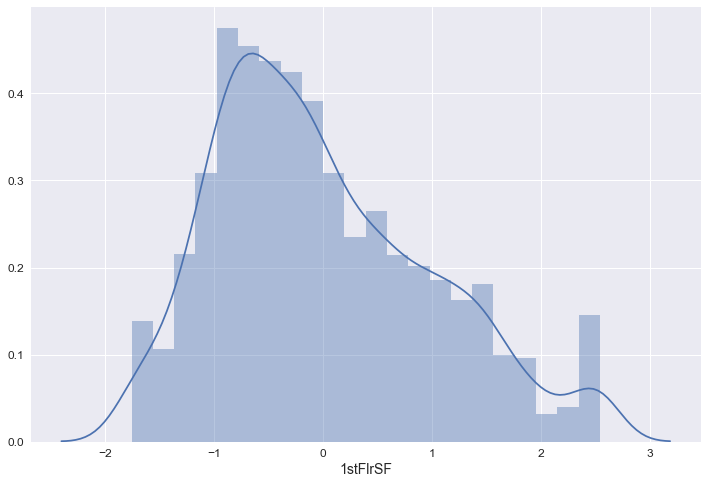

In [133]:
new["1stFlrSF"] = scaler.fit_transform(new[["1stFlrSF"]]) 
sns.distplot(new["1stFlrSF"]);

## 2ndFlrSF

In [134]:
data["2ndFlrSF"].describe()

count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
25%         0.000000
50%         0.000000
75%       704.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

In [135]:
np.sum(data["2ndFlrSF"] == 0)

1668

In [136]:
# Has 2nd floor?: Y (1) or No (0)
new["2ndFlr"] = np.where(data["2ndFlrSF"] == 0, 0, 1)
new["2ndFlr"].value_counts()

0    1668
1    1251
Name: 2ndFlr, dtype: int64

## GrLivArea

In [137]:
data["GrLivArea"].describe()

count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
25%      1126.000000
50%      1444.000000
75%      1743.500000
max      5642.000000
Name: GrLivArea, dtype: float64

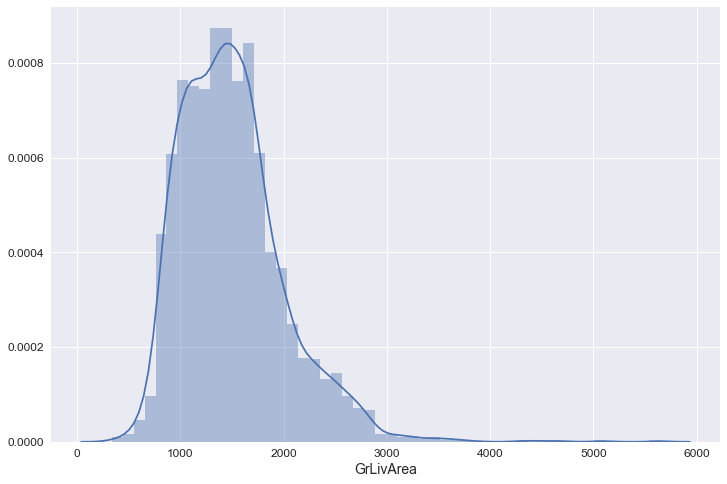

In [138]:
sns.distplot(data["GrLivArea"]);

In [139]:
np.corrcoef(data["GrLivArea"], data["1stFlrSF"])

array([[ 1.        ,  0.56253825],
       [ 0.56253825,  1.        ]])

There is a positive moderate correlation between GrLivArea and 1stFlrSF.

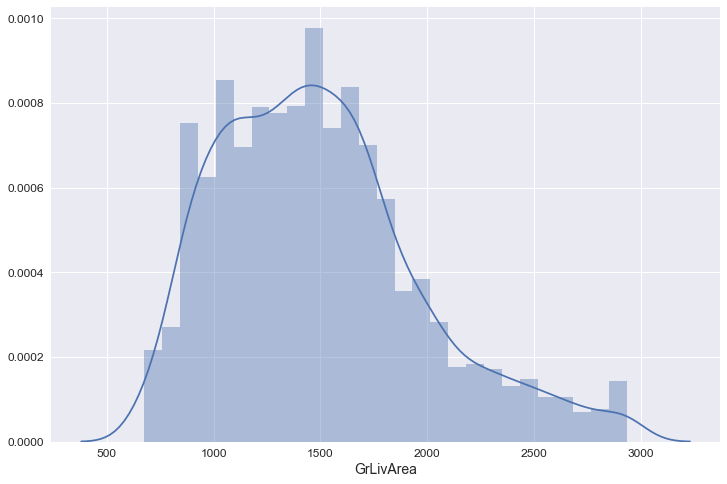

In [140]:
lowerbound, upperbound = np.percentile(data["GrLivArea"], [1, 99])
new["GrLivArea"] = np.clip(data["GrLivArea"], lowerbound, upperbound)
sns.distplot(new["GrLivArea"]);

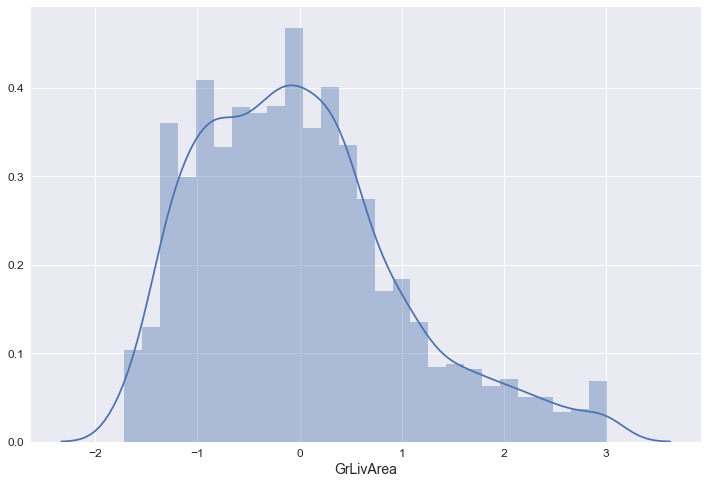

In [141]:
new["GrLivArea"] = scaler.fit_transform(new[["GrLivArea"]]) 
sns.distplot(new["GrLivArea"]);

## TotalArea: NEW feature

Ground living area is calculated by measuring the outside perimeter of the house and includes only finished, habitable, above-grade living space. Finished basements and unfinished attic areas are not included in total gross living area. Let's combine the ground living area with the total basement area to inform homeowners how much total area will be available to them. Note that the living area on the first floor is included in the ground living area calculations, which explains the correlation between the two variables.

In [142]:
new["TotalArea"] = pd.Series(np.sum([data["GrLivArea"], data["TotalBsmtSF"]], axis = 0))
new["TotalArea"].describe()

count     2919.000000
mean      2572.914012
std        823.597721
min        334.000000
25%       2014.000000
50%       2478.000000
75%       3009.000000
max      11752.000000
Name: TotalArea, dtype: float64

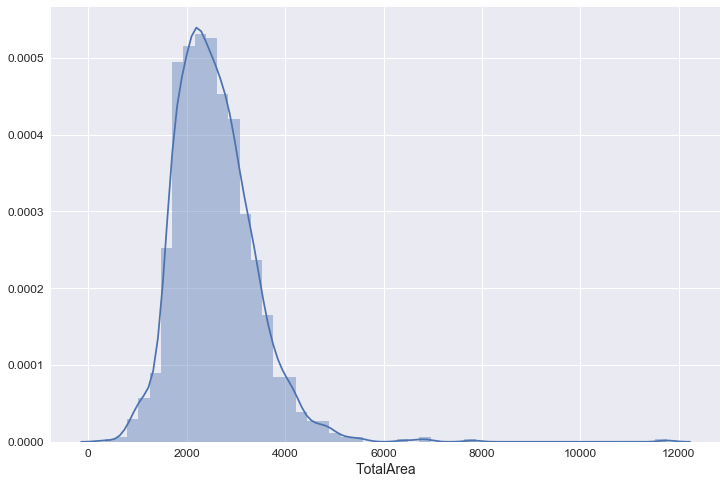

In [143]:
sns.distplot(new["TotalArea"]);

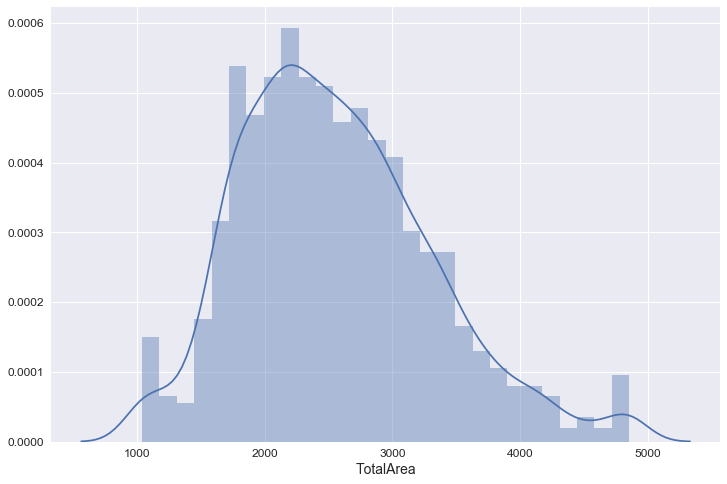

In [144]:
lowerbound, upperbound = np.percentile(new["TotalArea"], [1, 99])
new["TotalArea"] = np.clip(new["TotalArea"], lowerbound, upperbound)
sns.distplot(new["TotalArea"]);

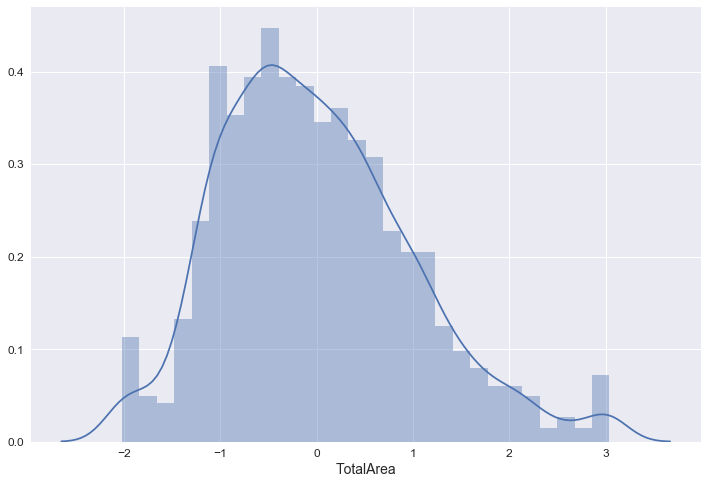

In [145]:
new["TotalArea"] = scaler.fit_transform(new[["TotalArea"]]) 
sns.distplot(new["TotalArea"]);

## LowQualFinSF

Drop this variable due to lack of data

In [146]:
data["LowQualFinSF"].describe()

count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1064.000000
Name: LowQualFinSF, dtype: float64

In [147]:
np.sum(data["LowQualFinSF"] == 0)

2879

## BsmtFullBath, BsmtHalfBath, FullBath, HalfBath

In [148]:
print data["BsmtFullBath"].isnull().sum()
print data["BsmtHalfBath"].isnull().sum()
print data["FullBath"].isnull().sum()
print data["HalfBath"].isnull().sum()

2
2
0
0


In [149]:
data["BsmtFullBath"].value_counts()

0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64

In [150]:
data["FullBath"].value_counts()

2    1530
1    1309
3      64
0      12
4       4
Name: FullBath, dtype: int64

Combine all full bathrooms, regardless of whether it is in the basement or not.

In [151]:
data["BsmtFullBath"].fillna(0, inplace=True)
full = pd.Series(np.sum([data["BsmtFullBath"], data["FullBath"]], axis = 0))
full.value_counts()

2.0    1466
1.0     758
3.0     645
4.0      44
6.0       5
0.0       1
dtype: int64

In [152]:
new["FullBath"] = full.replace([0, 1], 1).replace([3, 4, 6], 3)
new["FullBath"].value_counts()

2.0    1499
1.0     744
3.0     676
Name: FullBath, dtype: int64

Similarly, combine all half bathrooms.

In [153]:
data["BsmtHalfBath"].value_counts()

0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64

In [154]:
data["HalfBath"].value_counts()

0    1834
1    1060
2      25
Name: HalfBath, dtype: int64

In [155]:
data["BsmtHalfBath"] = data["BsmtHalfBath"].fillna(0)
half = pd.Series(np.sum([data["BsmtHalfBath"], data["HalfBath"]], axis = 0))
half.value_counts()

0.0    1700
1.0    1154
2.0      61
3.0       3
4.0       1
dtype: int64

Has half bathroom?: Y (1) or No (0)

In [156]:
new["HalfBath"] = half.map(lambda x: 1 if x > 0 else 0)
new["HalfBath"].value_counts()

0    1710
1    1209
Name: HalfBath, dtype: int64

## Bedroom

In [157]:
data["BedroomAbvGr"].value_counts()

3    1596
2     742
4     400
1     103
5      48
6      21
0       8
8       1
Name: BedroomAbvGr, dtype: int64

In [158]:
data["BedroomAbvGr"].isnull().sum()

0

In [159]:
new["BedroomAbvGr"] = data["BedroomAbvGr"].replace(0, 1).replace([4, 5, 6, 8], 4)
new["BedroomAbvGr"].value_counts()

3    1596
2     742
4     470
1     111
Name: BedroomAbvGr, dtype: int64

## KitchenAbvGr

Drop this variable due to lack of data. Also, KitchenQual assumes that a kitchen is available.

In [160]:
data["KitchenAbvGr"].value_counts()

1    2785
2     129
0       3
3       2
Name: KitchenAbvGr, dtype: int64

## KitchenQual

In [161]:
data["KitchenQual"].value_counts()

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

In [162]:
data["KitchenQual"].isnull().sum()

1

In [163]:
new["KitchenQual"] = data["KitchenQual"].fillna("TA").map({"Ex": 3, "Gd": 3, "TA": 2, "Fa": 1, "Po": 1})
new["KitchenQual"].value_counts()

2    1493
3    1356
1      70
Name: KitchenQual, dtype: int64

## TotRmsAbvGrd

In [164]:
data["TotRmsAbvGrd"].isnull().sum()

0

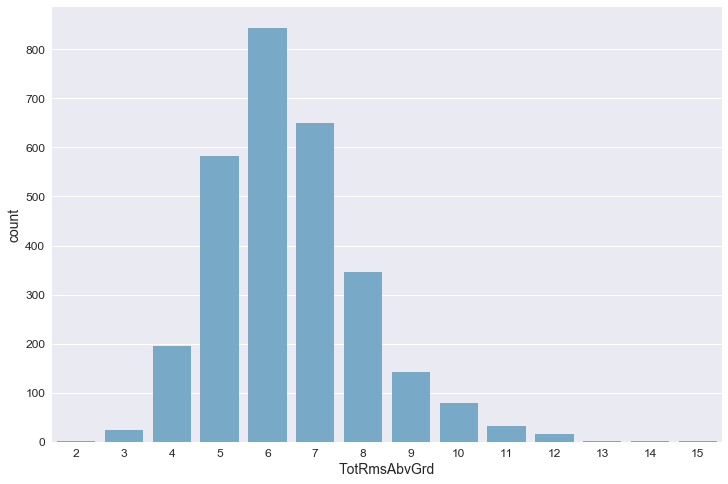

In [165]:
sns.countplot(x="TotRmsAbvGrd", data=data, palette=sns.color_palette("Blues", 1));

In [166]:
new["TotRmsAbvGrd"] = data["TotRmsAbvGrd"].replace([2, 3, 4], 4).replace([9, 10, 11, 12, 13, 14, 15], 9)
new["TotRmsAbvGrd"].value_counts()

6    844
7    649
5    583
8    347
9    274
4    222
Name: TotRmsAbvGrd, dtype: int64

## Functional

Drop due to lack of variability

In [167]:
data["Functional"].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [168]:
data["Functional"].isnull().sum()

2

In [169]:
# Typical home functionality?: Y (1) or No (0)
data["Functional"].fillna("Typ", inplace=True)
Functional = np.where(data["Functional"] == "Typ", 1, 0)
pd.Series(Functional).value_counts()

1    2719
0     200
dtype: int64

## Fireplaces

In [170]:
data["Fireplaces"].isnull().sum()

0

In [171]:
data["Fireplaces"].value_counts()

0    1420
1    1268
2     219
3      11
4       1
Name: Fireplaces, dtype: int64

In [172]:
# Has a fireplace?: Y (1) or No (0)
new["Fireplaces"] = np.where(data["Fireplaces"] > 0, 1, 0)
new["Fireplaces"].value_counts()

1    1499
0    1420
Name: Fireplaces, dtype: int64

## FireplaceQu

In [173]:
data["FireplaceQu"].isnull().sum()

1420

In [174]:
data["FireplaceQu"].value_counts()

Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64

NA means no fireplace, and not missing.

In [175]:
new["FireplaceQu"] = data["FireplaceQu"].fillna("None").map({"Ex": 3, "Gd": 3, "TA": 2, "Fa": 1, "Po": 1, "None": 0})
new["FireplaceQu"].value_counts()

0    1420
3     787
2     592
1     120
Name: FireplaceQu, dtype: int64

## GarageType

In [176]:
data["GarageType"].isnull().sum()

157

NA means No Garage, and doesn't mean missing.

In [177]:
data["GarageType"].fillna("None", inplace=True)
data["GarageType"].value_counts()

Attchd     1723
Detchd      779
BuiltIn     186
None        157
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

In [178]:
# Attached garage?: Y (1) or No (0)
new["GarageType"] = np.where(data["GarageType"] == "Attchd", 1, 0)
new["GarageType"].value_counts()

1    1723
0    1196
Name: GarageType, dtype: int64

## GarageYrBlt

In [179]:
data["GarageYrBlt"].describe()

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [180]:
data["GarageYrBlt"].isnull().sum()

159

Since 159 houses don't have garages, replace NA with 0, including the max year!

In [181]:
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(0).replace(data["GarageYrBlt"].max(), 0)
data["GarageYrBlt"].describe()

count    2919.000000
mean     1869.608085
std       450.973653
min         0.000000
25%      1957.000000
50%      1977.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

Let 0 = ancient, 1 = older, 2 = newer, 3 = modern indicate the age of the garage

In [182]:
# Bin years
new["GarageYrBlt"] = pd.qcut(data["YearBuilt"], q = 4, labels = [0, 1, 2, 3])
new["GarageYrBlt"].value_counts()

2    748
1    741
0    730
3    700
Name: GarageYrBlt, dtype: int64

## GarageFinish

In [183]:
data["GarageFinish"].isnull().sum()

159

NA means no garage, and not missing.

In [184]:
data["GarageFinish"].fillna("None", inplace=True)
data["GarageFinish"].value_counts()

Unf     1230
RFn      811
Fin      719
None     159
Name: GarageFinish, dtype: int64

In [185]:
new["GarageFinish"] = data["GarageFinish"]
new["GarageFinish"].value_counts()

Unf     1230
RFn      811
Fin      719
None     159
Name: GarageFinish, dtype: int64

In [186]:
# Frequency Encoding
freqGrg = new.groupby("GarageFinish").size() / len(new)
new["GarageFinish"] = new["GarageFinish"].map(freqGrg)
new["GarageFinish"].value_counts()

0.421377    1230
0.277835     811
0.246317     719
0.054471     159
Name: GarageFinish, dtype: int64

## GarageCars and GarageArea

In [187]:
data["GarageCars"].isnull().sum()

1

In [188]:
data["GarageCars"].value_counts()

2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: GarageCars, dtype: int64

In [189]:
data["GarageArea"].describe()

count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
25%       320.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64

In [190]:
data["GarageCars"] = data["GarageCars"].fillna(2)
data["GarageArea"] = data["GarageArea"].fillna(data["GarageArea"].median())

In [191]:
np.corrcoef(data["GarageCars"], data["GarageArea"])

array([[ 1.        ,  0.88968941],
       [ 0.88968941,  1.        ]])

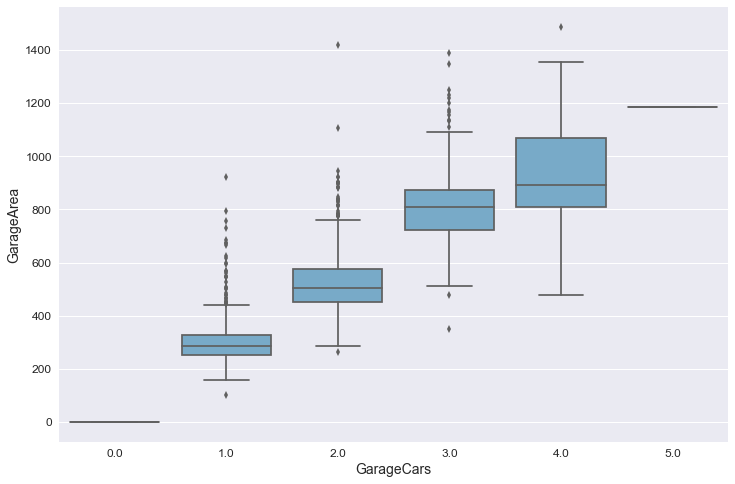

In [192]:
sns.boxplot(x="GarageCars", y="GarageArea", data=data, palette=sns.color_palette("Blues", 1));

It is clear from the graph that there is a relationship between GarageCars and GarageArea. In fact, both variables have a strong positive correlation of 0.89. Garages that can fit 1-3 cars form the three biggest clusters in the graph. We choose to merge garages that can fit more than 3 cars with the garages that can fit exactly three cars since they share same area square footage range and that data doesn't have much density. Also, in order to reduce redundancy, we keep only one of the two variables. We picked GarageCars since most people understand how many cars they can fit in their garage as opposed to its area. In fact, the number of cars that a garage can fit can be viewed as binning classes for the garage area.

In [193]:
new["GarageCars"] = data["GarageCars"].replace([3, 4, 5], 3)
new["GarageCars"].value_counts()

2.0    1595
1.0     776
3.0     391
0.0     157
Name: GarageCars, dtype: int64

## GarageQual and GarageCond

In [194]:
data["GarageQual"].isnull().sum()

159

NA means no garage, and not missing.

In [195]:
data["GarageQual"].fillna("None", inplace=True)
data["GarageQual"].value_counts()

TA      2604
None     159
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64

In [196]:
data["GarageCond"].isnull().sum()

159

In [197]:
data["GarageCond"].fillna("None", inplace=True)
data["GarageCond"].value_counts()

TA      2654
None     159
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64

Let's compare the original garage quality (GarageQual) to the current garage condition (GarageCond).

In [198]:
original = data["GarageQual"].map({"Ex": 4, "Gd": 4, "TA": 2, "Fa": 1, "Po": 1, "None": 0})
current = data["GarageCond"].map({"Ex": 4, "Gd": 4, "TA": 2, "Fa": 1, "Po": 1, "None": 0})
cond = np.subtract(current, original)
cond.value_counts()

 0    2779
 1      77
-1      36
-2      18
 2       9
Name: GarageCond, dtype: int64

In [199]:
GarageRemod = pd.Series(cond.map(lambda x: "depreciated" if x < 0 else "improved" if x > 0 else "no change"))
pd.Series(GarageRemod).value_counts()

no change      2779
improved         86
depreciated      54
Name: GarageCond, dtype: int64

In [200]:
# Was garage remodeled?: Y (1) or No (0)
GarageRemod = np.where(GarageRemod == "no change", 1, 0)
pd.Series(GarageRemod).value_counts()

1    2779
0     140
dtype: int64

Drop GarageRemod due to lack of variability

## WoodDeckSF

In [201]:
data["WoodDeckSF"].describe()

count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max      1424.000000
Name: WoodDeckSF, dtype: float64

In [202]:
np.sum(data["WoodDeckSF"] == 0)

1523

In [203]:
# Has a wood deck?: Y(1) or No (0)
new["WoodDeck"] = np.where(data["WoodDeckSF"] == 0, 0, 1)
new["WoodDeck"].value_counts()

0    1523
1    1396
Name: WoodDeck, dtype: int64

## OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch

In [204]:
data["OpenPorchSF"].describe()

count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
25%         0.000000
50%        26.000000
75%        70.000000
max       742.000000
Name: OpenPorchSF, dtype: float64

In [205]:
np.sum(data["OpenPorchSF"] == 0)

1298

In [206]:
data["EnclosedPorch"].describe()

count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64

In [207]:
np.sum(data["EnclosedPorch"] == 0)

2460

In [208]:
data["3SsnPorch"].describe()

count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

In [209]:
np.sum(data["3SsnPorch"] == 0)

2882

In [210]:
data["ScreenPorch"].describe()

count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       576.000000
Name: ScreenPorch, dtype: float64

In [211]:
np.sum(data["ScreenPorch"] == 0)

2663

In [212]:
new["TotalPorchSF"] = np.sum([data["OpenPorchSF"], 
                              data["EnclosedPorch"], 
                              data["3SsnPorch"], 
                              data["ScreenPorch"]], 
                             axis = 0)
new["TotalPorchSF"].describe()

count    2919.000000
mean       89.249743
std       107.902805
min         0.000000
25%         0.000000
50%        50.000000
75%       136.000000
max      1207.000000
Name: TotalPorchSF, dtype: float64

In [213]:
np.sum(new["TotalPorchSF"] == 0)

873

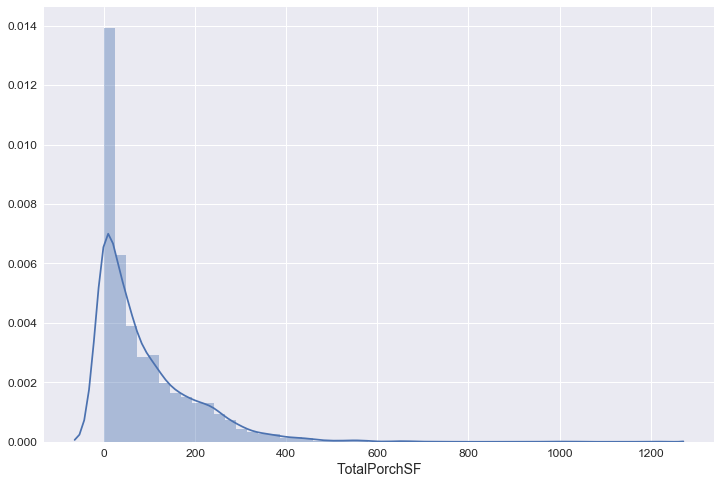

In [214]:
sns.distplot(new["TotalPorchSF"]);

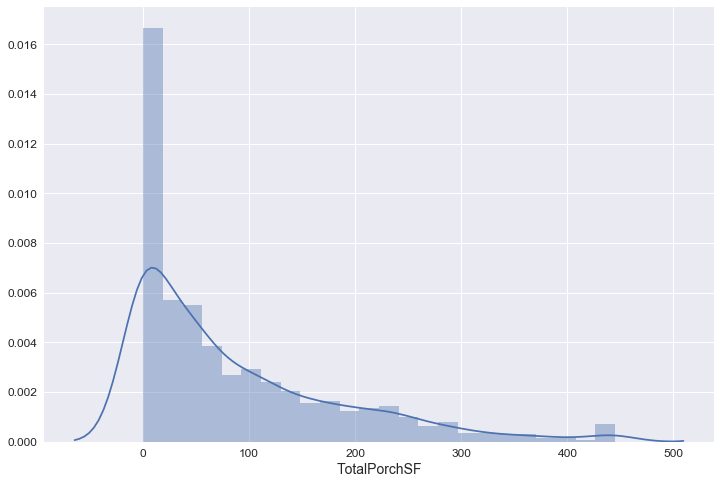

In [215]:
lowerbound, upperbound = np.percentile(new["TotalPorchSF"], [1, 99])
new["TotalPorchSF"] = np.clip(new["TotalPorchSF"], upperbound, lowerbound)
sns.distplot(new["TotalPorchSF"]);

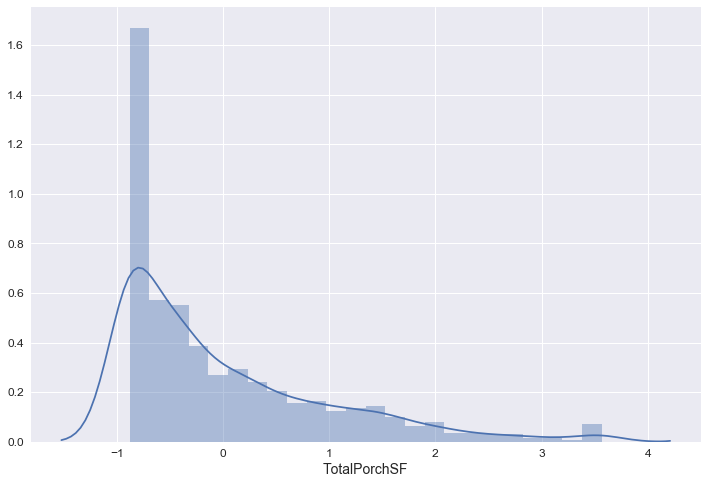

In [216]:
new["TotalPorchSF"] = scaler.fit_transform(new[["TotalPorchSF"]]) 
sns.distplot(new["TotalPorchSF"]);

## PoolArea and PoolQC

In [217]:
data["PoolArea"].describe()

count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       800.000000
Name: PoolArea, dtype: float64

In [218]:
np.sum(data["PoolArea"] == 0)

2906

An overwhelming majority of the houses don't have a pool! Drop both PoolArea and PoolQC.

In [219]:
data["PoolQC"].value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

## Fence

In [220]:
data["Fence"].isnull().sum()

2348

NA means no fence, and not missing. Drop Fence due to lack of variability

In [221]:
# Has Fence?: Y (1) or No (0)
Fence = np.where(data["Fence"].isnull(), 0 , 1)
pd.Series(Fence).value_counts()

0    2348
1     571
dtype: int64

## MiscFeature and MiscVal

In [222]:
data["MiscFeature"].isnull().sum()

2814

NA means no miscellaneous features, and not missing. Since vast majority of the houses don't have miscellaneous features, there is no need to investigate its dollar value. Drop both variables.

In [223]:
data["MiscVal"].describe()

count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      17000.000000
Name: MiscVal, dtype: float64

In [224]:
np.sum(data["MiscVal"] == 0)

2816

## MoSold

In [225]:
data["MoSold"].isnull().sum()

0

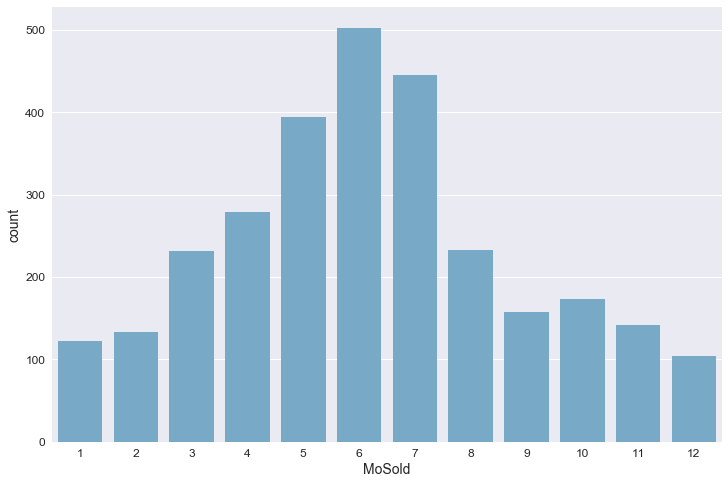

In [226]:
sns.countplot(x="MoSold", data=data, palette=sns.color_palette("Blues", 1));

In [227]:
new["MoSold"] = data["MoSold"].map({12: "winter", 1: "winter", 2: "winter",
                                    3: "spring", 4: "spring", 5: "spring",
                                    6: "summer", 7: "summer", 8: "summer",
                                    9: "fall", 10: "fall", 11: "fall"})
new["MoSold"].value_counts()

summer    1182
spring     905
fall       473
winter     359
Name: MoSold, dtype: int64

In [228]:
# Frequency Encoding
freqMo = new.groupby("MoSold").size() / len(new)
new["MoSold"] = new["MoSold"].map(freqMo)
new["MoSold"].value_counts()

0.404933    1182
0.310038     905
0.162042     473
0.122987     359
Name: MoSold, dtype: int64

## YrSold

In [229]:
data["YrSold"].value_counts()

2007    692
2009    647
2008    622
2006    619
2010    339
Name: YrSold, dtype: int64

In [230]:
data["YrSold"].describe()

count    2919.000000
mean     2007.792737
std         1.314964
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

In [231]:
new["YrSold"] = data["YrSold"]

## SaleType

In [232]:
data["SaleType"].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

Drop SaleType since most houses had conventional warranty deed

## SaleCondition

In [233]:
data["SaleCondition"].value_counts()

Normal     2402
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64

Drop SaleCondition since most sales were normal

## SalePrice

In [234]:
tr["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

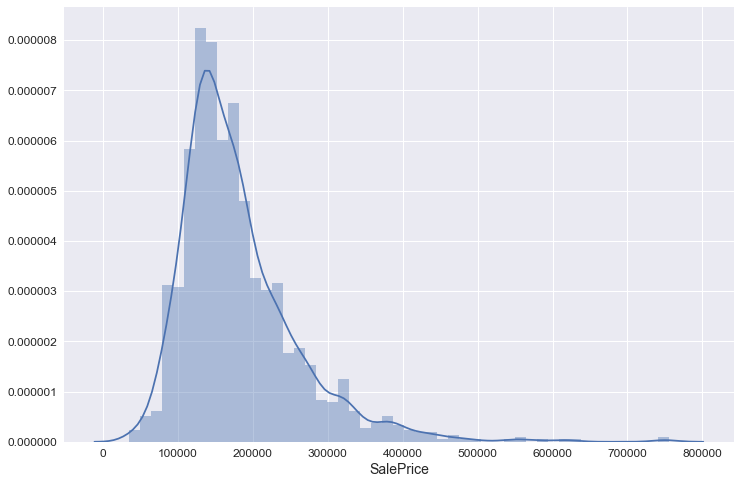

In [235]:
sns.distplot(tr["SalePrice"]);

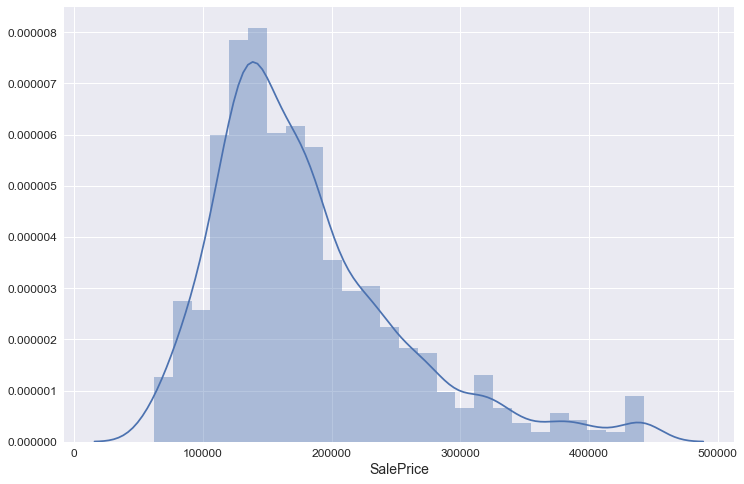

In [236]:
lowerbound, upperbound = np.percentile(tr["SalePrice"], [1, 99])
tr["SalePrice"] = np.clip(tr["SalePrice"], upperbound, lowerbound)
sns.distplot(tr["SalePrice"]);

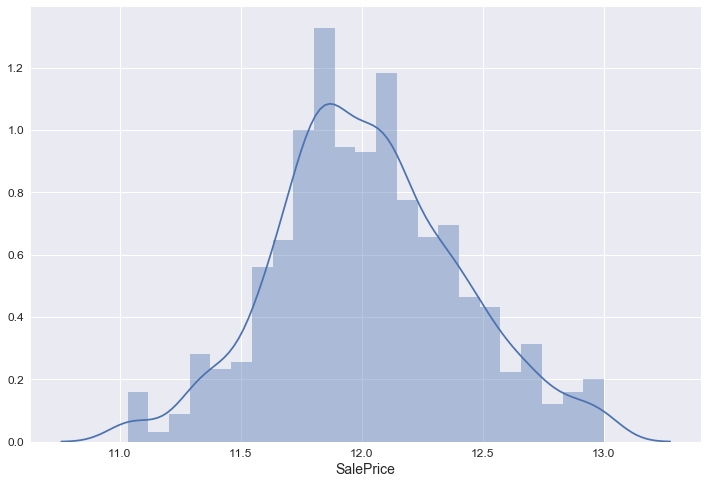

In [237]:
tr["SalePrice"] = np.log1p(tr[["SalePrice"]])  # log(x+1) transform
sns.distplot(tr["SalePrice"]);

# Pre-processed New Data

In [238]:
new.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,YearBuilt,RemodAdd,Exterior,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,WoodDeck,TotalPorchSF,MoSold,YrSold
0,2,-0.192326,-0.310111,1,1,0.091470,2,3,0,0.351148,...,0,0,1,3,0.277835,2.0,0,-0.267194,0.122987,2008
1,1,0.572511,0.013750,1,0,0.008222,1,2,0,0.154162,...,1,2,1,2,0.277835,2.0,1,-0.876307,0.310038,2007
2,2,-0.039359,0.478420,0,1,0.091470,2,2,1,0.351148,...,1,2,1,2,0.277835,2.0,0,-0.456918,0.162042,2008
3,2,-0.447272,-0.000331,0,0,0.035286,2,0,1,0.140802,...,1,3,0,0,0.421377,3.0,0,2.189228,0.122987,2006
4,2,0.776467,1.326090,0,0,0.024323,2,2,0,0.351148,...,1,2,1,2,0.277835,3.0,1,-0.037529,0.122987,2008


In [239]:
new.columns

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'LotShape', u'LotConfig',
       u'Neighborhood', u'HouseStyle', u'YearBuilt', u'RemodAdd', u'Exterior',
       u'MasVnr', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtExposure',
       u'TotalBsmtSF', u'HeatingQC', u'1stFlrSF', u'2ndFlr', u'GrLivArea',
       u'TotalArea', u'FullBath', u'HalfBath', u'BedroomAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Fireplaces', u'FireplaceQu', u'GarageType',
       u'GarageYrBlt', u'GarageFinish', u'GarageCars', u'WoodDeck',
       u'TotalPorchSF', u'MoSold', u'YrSold'],
      dtype='object')

In [240]:
xTrain = new[:1460]  # extract rows 0 to 1459
test = new[1460:]  # extract rest of the rows
yTrain = tr["SalePrice"]  # append SalePrice column

print xTrain.shape
print test.shape

(1460, 36)
(1459, 36)


# Random Forest

In [241]:
# Tune parameters
# gridRF = GridSearchCV(RandomForestRegressor(min_samples_leaf=3, n_jobs=-1), 
#                       cv=5, 
#                       param_grid={"n_estimators": [100, 300, 500, 700, 900]})
# gridRF.fit(xTrain, yTrain)
# gridRF.best_params_

In [242]:
# Create validation dataset with 60/40 split
xTrainVal, xTestVal, yTrainVal, yTestVal = train_test_split(xTrain, yTrain, test_size=.4)

In [243]:
# Train on validation train data
rf =  RandomForestRegressor(n_estimators=700,
                             min_samples_leaf=3, 
                             n_jobs=-1)
rf.fit(X=xTrainVal, y=yTrainVal)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [244]:
# Predict on validation test data
yPredVal = rf.predict(xTestVal)

In [245]:
# Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(yTestVal, yPredVal))

0.14112748822324031

In [246]:
# Feature importance
featImp = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), xTrain.columns),
                 reverse=True)
featImp

[(0.6565, 'TotalArea'),
 (0.094, 'KitchenQual'),
 (0.0367, 'GarageCars'),
 (0.027, 'BsmtQual'),
 (0.0199, 'Neighborhood'),
 (0.0189, 'GrLivArea'),
 (0.014, 'LotArea'),
 (0.0125, 'LotFrontage'),
 (0.0096, '1stFlrSF'),
 (0.0092, 'TotalPorchSF'),
 (0.0088, 'TotalBsmtSF'),
 (0.0085, 'FireplaceQu'),
 (0.0081, 'GarageYrBlt'),
 (0.0078, 'Foundation'),
 (0.0073, 'YearBuilt'),
 (0.0072, 'ExterCond'),
 (0.0061, 'FullBath'),
 (0.0051, 'GarageFinish'),
 (0.0051, 'Exterior'),
 (0.005, 'HeatingQC'),
 (0.0039, 'YrSold'),
 (0.0036, 'HalfBath'),
 (0.0036, 'BedroomAbvGr'),
 (0.0035, 'MoSold'),
 (0.0034, 'Fireplaces'),
 (0.0024, 'GarageType'),
 (0.0021, 'MSSubClass'),
 (0.0019, 'TotRmsAbvGrd'),
 (0.0015, 'LotShape'),
 (0.0013, 'RemodAdd'),
 (0.0012, 'WoodDeck'),
 (0.0012, 'BsmtExposure'),
 (0.0011, 'HouseStyle'),
 (0.0008, 'LotConfig'),
 (0.0007, 'MasVnr'),
 (0.0003, '2ndFlr')]

In [247]:
# Predict on test data and write to CSV
yTest = rf.predict(test)
submissionRF = pd.DataFrame({"Id": range(1461, len(yTest)+1461), 
                             "SalePrice": np.expm1(yTest)})  # inverse of log(x+1)
submissionRF.to_csv("../submission/submissionRF.csv", index=False)